### Single Pass Spectrogram Inversion

Reconstruct an audio signal from a magnitude spectrum with but a single ifft.<br>

Cite and more info: <br>
    Beauregard, G., Harish, M. and Wyse, L. (2015), Single Pass Spectrogram Inversion, <br>
    in Proceedings of the IEEE International Conference on Digital Signal Processing. Singapore, 2015.<br>
    [Phase reconstruction homepage.](http://anclab.org/software/phaserecon/)

In [85]:
import numpy as np
import librosa
import math
import scipy

print('You are using librosa version ' + librosa.__version__)

You are using librosa version 0.5.0


In [81]:
def spsi(msgram, fftsize, hop_length) :
    """
    Takes a 2D spectrogram ([freqs,frames]), the fft legnth (= widnow length) and the hope size (both in units of samples).
    Returns an audio signal.
    """
    
    numBins, numFrames  = msgram.shape
    y_out=np.zeros(numFrames*hop_length+fftsize-hop_length)
        
    m_phase=np.zeros(numBins);      
    m_win=scipy.signal.hanning(fftsize, sym=True)  # assumption here that hann was used to create the frames of the spectrogram
    
    #processes one frame of audio at a time
    for i in range(numFrames) :
            m_mag=msgram[:, i] 
            for j in range(1,numBins-1) : 
                if(m_mag[j]>m_mag[j-1] and m_mag[j]>m_mag[j+1]) : #if j is a peak
                    alpha=m_mag[j-1];
                    beta=m_mag[j];
                    gamma=m_mag[j+1];
                    denom=alpha-2*beta+gamma;
                    
                    if(denom!=0) :
                        p=0.5*(alpha-gamma)/denom;
                    else :
                        p=0;
                        
                    phaseRate=2*math.pi*(j-1+p)/fftsize;    #adjusted phase rate
                    m_phase[j]= m_phase[j] + hop_length*phaseRate; #phase accumulator for this peak bin
                    peakPhase=m_phase[j];
                    
                    # If actual peak is to the right of the bin freq
                    if (p>0) :
                        # First bin to right has pi shift
                        bin=j+1;
                        m_phase[bin]=peakPhase+math.pi;
                        
                        # Bins to left have shift of pi
                        bin=j-1;
                        while((bin>1) and (m_mag[bin]<m_mag[bin+1])) : # until you reach the trough
                            m_phase[bin]=peakPhase+math.pi;
                            bin=bin-1;
                        
                        #Bins to the right (beyond the first) have 0 shift
                        bin=j+2;
                        while((bin<(numBins)) and (m_mag[bin]<m_mag[bin-1])) :
                            m_phase[bin]=peakPhase;
                            bin=bin+1;
                            
                    #if actual peak is to the left of the bin frequency
                    if(p<0) :
                        # First bin to left has pi shift
                        bin=j-1;
                        m_phase[bin]=peakPhase+math.pi;

                        # and bins to the right of me - here I am stuck in the middle with you
                        bin=j+1;
                        while((bin<(numBins)) and (m_mag[bin]<m_mag[bin-1])) :
                            m_phase[bin]=peakPhase+math.pi;
                            bin=bin+1;
                        
                        # and further to the left have zero shift
                        bin=j-2;
                        while((bin>1) and (m_mag[bin]<m_mag[bin+1])) : # until trough
                            m_phase[bin]=peakPhase;
                            bin=bin-1;
                            
                #end ops for peaks
            #end loop over fft bins with

            magphase=m_mag*np.exp(1j*m_phase)  #reconstruct with new phase (elementwise mult)
            magphase[0]=0; magphase[numBins-1] = 0 #remove dc and nyquist
            m_recon=np.concatenate([magphase,np.flip(np.conjugate(magphase[1:numBins-1]), 0)]) 
            
            #overlap and add
            m_recon=np.real(np.fft.ifft(m_recon))*m_win
            y_out[i*hop_length:i*hop_length+fftsize]+=m_recon
            
    return y_out

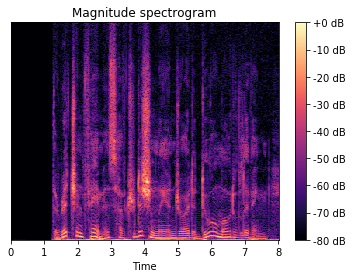

In [82]:
# Test
import matplotlib.pyplot as plt
%matplotlib inline
import librosa.display
import IPython.display

fftsize=1024
hop_length=256

y, sr = librosa.load('sounds/BeingRural_short.wav')
D = librosa.stft(y, fftsize, hop_length=hop_length)
magD=np.abs(D)

librosa.display.specshow(librosa.amplitude_to_db(magD,ref=np.max), x_axis='time')
plt.title('Magnitude spectrogram')
plt.colorbar(format='%+2.0f dB')

y_out = spsi(magD, fftsize=fftsize, hop_length=hop_length)


In [83]:
# Original
IPython.display.Audio(data=y, rate=sr)

In [84]:
# Single pass reconstruction from mag spectrogram
IPython.display.Audio(data=y_out, rate=sr)

Note: Try this as an initial phase estimate for Griffin & Lim reconstruction to save time and electricity!